<a href="https://colab.research.google.com/github/ubermenchh/vit-pytorch/blob/main/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 636.1 kB/s eta 0:00:00


#ViT Architecture

In [2]:
import torch
from torch import nn
from einops import rearrange
from einops.layers.torch import Rearrange

In [3]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

In [4]:
def posemb_sincos_2d(h, w, dim, temperature=10000, dtype=torch.float32):
    y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing='ij')
    assert (dim % 4) == 0, "feature dimension must be multiple of 4 for sincos emb"
    omega = torch.arange(dim // 4) / (dim // 4 - 1)
    omega = 1.0 / (temperature**omega)

    y = y.flatten()[:, None] * omega[None, :]
    x = x.flatten()[:, None] * omega[None, :]
    pe = torch.cat((x.sin(), x.cos(), y.sin(), y.cos()), dim=1)
    return pe.type(dtype)

In [5]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        return self.net(x)

In [6]:
class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head**-0.5
        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim=-1)

        self.to_qkv = nn.Linear(dim, inner_dim*3, bias=False)
        self.to_out = nn.Linear(inner_dim, dim, bias=False)

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, "b n (h d) -> b h n d", h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, "b h n d -> b n (h d)")
        return self.to_out(out)

In [7]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads=heads, dim_head=dim_head),
                FeedForward(dim, mlp_dim)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return self.norm(x)

In [8]:
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3, dim_head=64):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange("b c (h p1) (w p2) -> b (h w) (p1 p2 c)", p1=patch_height, p2=patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim)
        )

        self.pos_embedding = posemb_sincos_2d(
            h = image_height // patch_height,
            w = image_width // patch_width,
            dim = dim
        )

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim)
        self.pool = "mean"
        self.to_latent = nn.Identity()
        self.linear_head = nn.Linear(dim, num_classes)

    def forward(self, img):
        device = img.device

        x = self.to_patch_embedding(img)
        x += self.pos_embedding.to(device, dtype=x.dtype)

        x = self.transformer(x)
        x = x.mean(dim=1)

        x = self.to_latent(x)
        return self.linear_head(x)

# Data Processing

In [9]:
from torchvision import transforms

train_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.RandomResizedCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize(48),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
    ]
)

In [10]:
import torchvision

train_data = torchvision.datasets.CIFAR10(root='./data/train/', train=True, download=True, transform=train_transforms)
test_data = torchvision.datasets.CIFAR10(root='./data/test/', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:01<00:00, 98705770.54it/s] 


Extracting ./data/train/cifar-10-python.tar.gz to ./data/train/


100%|██████████| 170498071/170498071 [00:01<00:00, 96181491.83it/s]


Extracting ./data/test/cifar-10-python.tar.gz to ./data/test/


In [11]:
import matplotlib.pyplot as plt

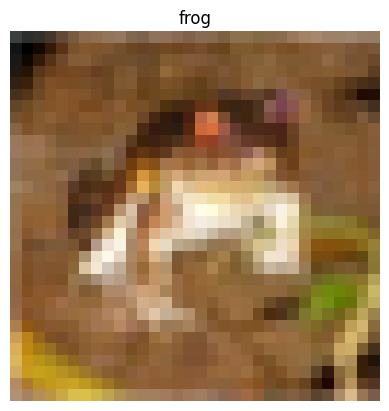

In [12]:
plt.title(train_data.classes[train_data.targets[0]])
plt.imshow(train_data.data[0])
plt.axis(False);

In [13]:
import numpy as np

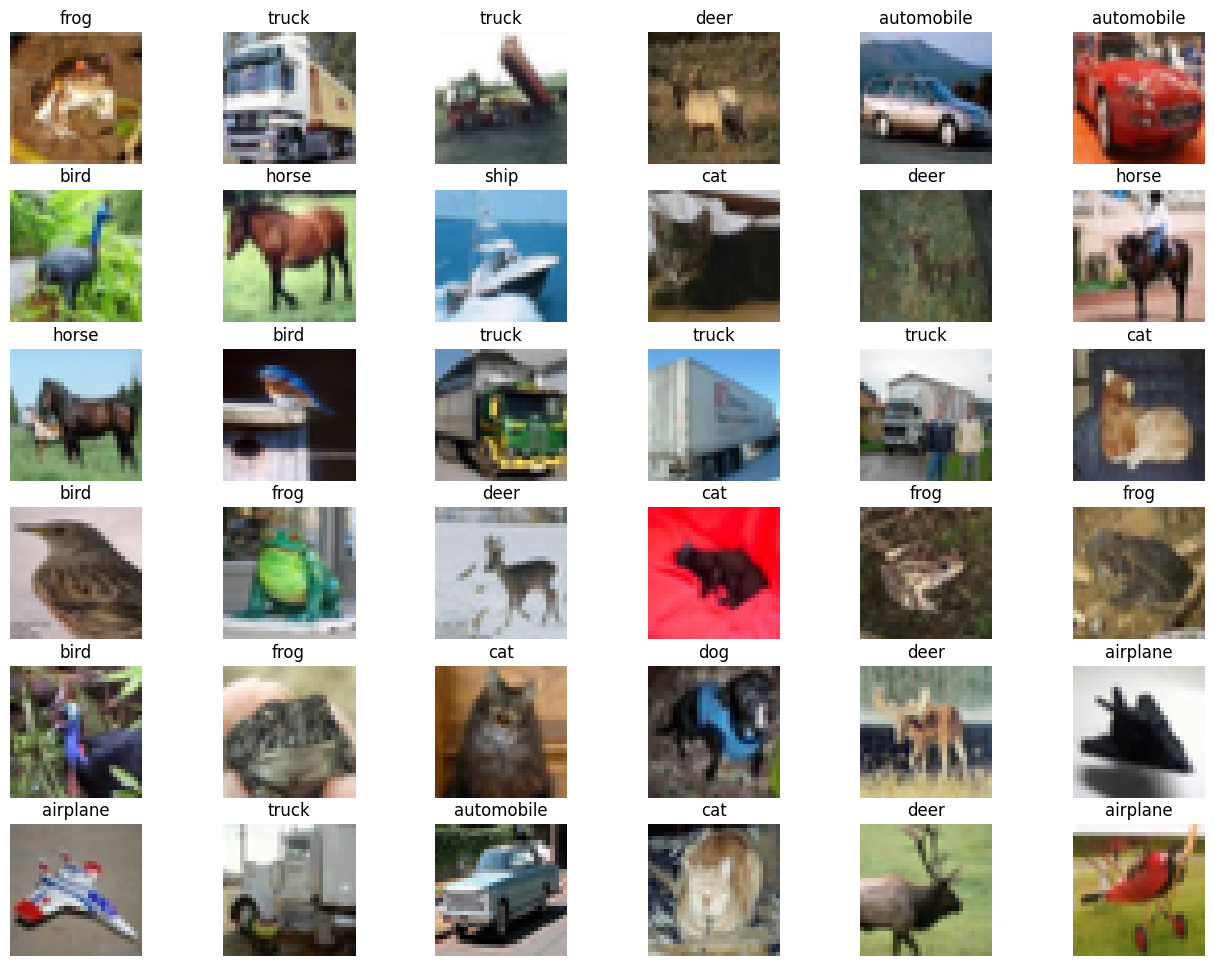

In [14]:
random_idx = np.random.randint(1, len(train_data), size=36)
fig, axes = plt.subplots(6, 6, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    ax.set_title(train_data.classes[train_data.targets[idx]])
    ax.imshow(train_data.data[idx])
    ax.axis('off')

# Training

In [15]:
batch_size = 64
epochs = 20
lr = 3e-4
gamma = 0.7

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
from torch.utils.data import Dataset, DataLoader

In [17]:
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

In [18]:
print(len(train_loader), len(test_loader))

782 157


In [19]:
num_classes = len(train_data.classes)
num_classes

10

In [20]:
model = ViT(
    image_size=32,
    patch_size=4,
    num_classes=num_classes,
    dim=128,
    depth=12,
    heads=8,
    mlp_dim=64
).to(device)

In [21]:
from torchsummary import summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1               [-1, 64, 48]               0
         LayerNorm-2               [-1, 64, 48]              96
            Linear-3              [-1, 64, 128]           6,272
         LayerNorm-4              [-1, 64, 128]             256
         LayerNorm-5              [-1, 64, 128]             256
            Linear-6             [-1, 64, 1536]         196,608
           Softmax-7            [-1, 8, 64, 64]               0
            Linear-8              [-1, 64, 128]          65,536
         Attention-9              [-1, 64, 128]               0
        LayerNorm-10              [-1, 64, 128]             256
           Linear-11               [-1, 64, 64]           8,256
             GELU-12               [-1, 64, 64]               0
           Linear-13              [-1, 64, 128]           8,320
      FeedForward-14              [-1, 

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)

In [23]:
from tqdm import tqdm

In [24]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_test_accuracy = 0
        epoch_test_loss = 0
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)

            test_output = model(data)
            test_loss = criterion(test_output, label)

            acc = (test_output.argmax(dim=1) == label).float().mean()
            epoch_test_accuracy += acc / len(test_loader)
            epoch_test_loss += test_loss / len(test_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - test_loss : {epoch_test_loss:.4f} - test_acc: {epoch_test_accuracy:.4f}\n"
    )

100%|██████████| 782/782 [00:48<00:00, 16.02it/s]


Epoch : 1 - loss : 1.7988 - acc: 0.3317 - test_loss : 1.5007 - test_acc: 0.4501



100%|██████████| 782/782 [00:49<00:00, 15.69it/s]


Epoch : 2 - loss : 1.5533 - acc: 0.4358 - test_loss : 1.3451 - test_acc: 0.5144



100%|██████████| 782/782 [00:48<00:00, 16.14it/s]


Epoch : 3 - loss : 1.4755 - acc: 0.4684 - test_loss : 1.3438 - test_acc: 0.5121



100%|██████████| 782/782 [00:48<00:00, 16.03it/s]


Epoch : 4 - loss : 1.4107 - acc: 0.4912 - test_loss : 1.1976 - test_acc: 0.5837



100%|██████████| 782/782 [00:49<00:00, 15.94it/s]


Epoch : 5 - loss : 1.3691 - acc: 0.5085 - test_loss : 1.1707 - test_acc: 0.5784



100%|██████████| 782/782 [00:49<00:00, 15.94it/s]


Epoch : 6 - loss : 1.3266 - acc: 0.5250 - test_loss : 1.1419 - test_acc: 0.5989



100%|██████████| 782/782 [00:49<00:00, 15.95it/s]


Epoch : 7 - loss : 1.3006 - acc: 0.5353 - test_loss : 1.0853 - test_acc: 0.6122



100%|██████████| 782/782 [00:49<00:00, 15.78it/s]


Epoch : 8 - loss : 1.2671 - acc: 0.5460 - test_loss : 1.0558 - test_acc: 0.6243



100%|██████████| 782/782 [00:48<00:00, 15.97it/s]


Epoch : 9 - loss : 1.2503 - acc: 0.5552 - test_loss : 1.0709 - test_acc: 0.6170



100%|██████████| 782/782 [00:48<00:00, 16.08it/s]


Epoch : 10 - loss : 1.2260 - acc: 0.5622 - test_loss : 1.0342 - test_acc: 0.6391



100%|██████████| 782/782 [00:48<00:00, 16.04it/s]


Epoch : 11 - loss : 1.2134 - acc: 0.5642 - test_loss : 1.0078 - test_acc: 0.6452



100%|██████████| 782/782 [00:48<00:00, 16.01it/s]


Epoch : 12 - loss : 1.1907 - acc: 0.5763 - test_loss : 0.9891 - test_acc: 0.6529



100%|██████████| 782/782 [00:48<00:00, 16.05it/s]


Epoch : 13 - loss : 1.1722 - acc: 0.5825 - test_loss : 0.9681 - test_acc: 0.6544



100%|██████████| 782/782 [00:48<00:00, 16.03it/s]


Epoch : 14 - loss : 1.1635 - acc: 0.5854 - test_loss : 0.9545 - test_acc: 0.6658



100%|██████████| 782/782 [00:49<00:00, 15.65it/s]


Epoch : 15 - loss : 1.1455 - acc: 0.5929 - test_loss : 1.0049 - test_acc: 0.6462



100%|██████████| 782/782 [00:48<00:00, 15.99it/s]


Epoch : 16 - loss : 1.1358 - acc: 0.5955 - test_loss : 0.9670 - test_acc: 0.6576



100%|██████████| 782/782 [00:48<00:00, 16.08it/s]


Epoch : 17 - loss : 1.1277 - acc: 0.5984 - test_loss : 0.9297 - test_acc: 0.6716



100%|██████████| 782/782 [00:48<00:00, 16.03it/s]


Epoch : 18 - loss : 1.1080 - acc: 0.6072 - test_loss : 0.9137 - test_acc: 0.6794



100%|██████████| 782/782 [00:48<00:00, 16.08it/s]


Epoch : 19 - loss : 1.0985 - acc: 0.6104 - test_loss : 0.9020 - test_acc: 0.6889



100%|██████████| 782/782 [00:48<00:00, 16.03it/s]


Epoch : 20 - loss : 1.0919 - acc: 0.6126 - test_loss : 0.8820 - test_acc: 0.6955



# Inference

In [25]:
test_img = test_data.data[69]

In [35]:
torch.tensor(test_img)

tensor([[[255, 255, 255],
         [219, 220, 221],
         [231, 232, 233],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [221, 222, 223],
         [228, 229, 229],
         ...,
         [254, 254, 254],
         [254, 254, 254],
         [255, 254, 254]],

        [[255, 255, 255],
         [226, 227, 228],
         [226, 226, 227],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [253, 255, 255]],

        ...,

        [[ 77,  89,  48],
         [ 78,  86,  47],
         [ 72,  80,  42],
         ...,
         [ 59,  76,  31],
         [ 64,  81,  35],
         [ 73,  85,  49]],

        [[ 68,  85,  41],
         [ 69,  81,  38],
         [ 70,  80,  44],
         ...,
         [ 56,  70,  29],
         [ 53,  69,  29],
         [ 63,  77,  41]],

        [[ 67,  88,  44],
         [ 65,  79,  37],
         [ 69,  80,  41],
         ...,
         [ 55,  64,  31],
        

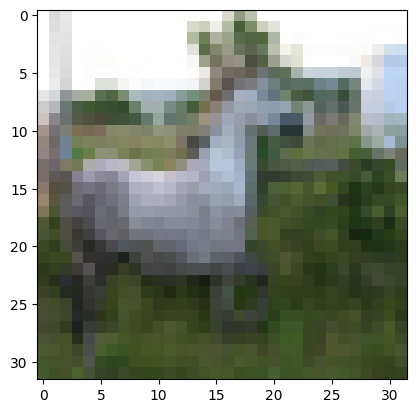

In [33]:
plt.imshow(test_img)

In [42]:
test_img = torch.tensor(test_img).permute(2, 0, 1)

In [43]:
model(test_img)

KeyError: ignored